In [328]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import datetime
from datetime import timedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from numpy import NaN
import seaborn as sns

In [242]:
CURRENT_LOCATION = "rov"

In [241]:
path_to_file = 'APPA_data_merged.csv'
df = pd.read_csv(path_to_file, parse_dates=["Data"])
df_bolz_pm10 = df[(df.Stazione == "Rovereto") & (df.Inquinante == "PM10")]

In [243]:
station_list = df.Stazione.unique()
pollutants_per_station = {}
for st in station_list:
    pollutants_per_station[st] = df[df.Stazione == st].Inquinante.unique().tolist()

pollutants_per_station

{'A22 (Avio)': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10'],
 'Borgo Valsugana': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Monte Gaza': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Parco S. Chiara': ['Biossido Zolfo',
  'Biossido di Azoto',
  'Ozono',
  'PM10',
  'PM2.5'],
 'Piana Rotaliana': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Riva del Garda': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Rovereto': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Via Bolzano': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10']}

Makes the daily mean from the hour values

In [244]:
df_daily = df_bolz_pm10.resample("D", on='Data').mean()
df_daily = df_daily.reset_index()

In [245]:
df_daily.head()

,Data,Valore
0,2012-01-01,38.521739
1,2012-01-02,39.791667
2,2012-01-03,19.166667
3,2012-01-04,23.875000
4,2012-01-05,19.958333


In [246]:
weather_file_path = "weather_data.csv"
weather_df = pd.read_csv(weather_file_path, parse_dates=["Data"])

In [247]:
locations = list(set(weather_df.columns[1:].map(lambda x: x.split()[0])))
locations

['borgo', 'rg', 'avio', 'bolz', 'mgazza', 'parco', 'piana', 'rov']

In [248]:
weather_loc = {}

for location in locations:
    location_columns = weather_df.columns[
        weather_df.columns.map(lambda x: x.split()[0] == location)
    ]

    location_df = weather_df[["Data"] + location_columns.tolist()]
    location_df.columns = location_df.columns.str.replace(location, "").str.strip()
    location_df["Location"] = location
    
    weather_loc[location] = location_df


C:\Users\thoma\AppData\Local\Temp\ipykernel_2228\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_2228\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_2228\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [249]:
df_weather_long = pd.concat(weather_loc.values())
# df_weather_long.to_csv("./weather_long_format.csv", index=None)

In [250]:
merged_df = df_daily.join(
    df_weather_long[df_weather_long.Location == CURRENT_LOCATION].set_index("Data"), 
    on="Data"
)
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol
0,2012-01-01,38.521739,0.0,0.8,rov,73.5,183.0,0.9,997.1,3615.3
1,2012-01-02,39.791667,17.4,0.8,rov,88.5,194.0,1.0,996.0,998.3
2,2012-01-03,19.166667,1.0,3.3,rov,93.7,169.0,1.0,998.9,4112.6
3,2012-01-04,23.875000,0.0,1.1,rov,90.3,174.0,1.0,995.2,2201.1
4,2012-01-05,19.958333,0.4,1.6,rov,75.6,179.0,1.4,981.9,3931.4
...,...,...,...,...,...,...,...,...,...,...
3837,2022-07-04,14.250000,2.8,24.5,rov,63.1,320.0,2.0,992.4,18361.3
3838,2022-07-05,8.125000,0.8,25.3,rov,59.3,331.0,1.3,990.5,25412.8
3839,2022-07-06,10.875000,0.2,25.7,rov,57.6,115.0,1.4,992.5,25734.4
3840,2022-07-07,14.833333,0.0,25.7,rov,52.7,32.0,1.6,991.1,23376.6


In [251]:
# add column for the value of the previous day
weather_parameters = ['rain', 'temp', 'press', 'hum', 'w_dir', 'w_sp', 'sol']
prev_day_values = {}
for par in weather_parameters:
    for i in range(1, 8):
        prev_day_values[f"{par} {i} day/s earlier"]  = []
        for date in merged_df["Data"]:
            prev_day = date - timedelta(hours=int(24 * i))
            series = merged_df[merged_df.Data == prev_day][par].values.tolist()
            #print(series)
            if len(series) > 0:
                value = series[0]
            else:
                value = NaN  # takes the current day, not the previous
            prev_day_values[f"{par} {i} day/s earlier"].append(value)

        merged_df[f"{par} {i} day/s earlier"] = prev_day_values[f'{par} {i} day/s earlier']

In [252]:
merged_df = merged_df.dropna()

In [253]:
merged_df.isna().sum()

Data                     0
Valore                   0
rain                     0
temp                     0
Location                 0
hum                      0
w_dir                    0
w_sp                     0
press                    0
sol                      0
rain 1 day/s earlier     0
rain 2 day/s earlier     0
rain 3 day/s earlier     0
rain 4 day/s earlier     0
rain 5 day/s earlier     0
rain 6 day/s earlier     0
rain 7 day/s earlier     0
temp 1 day/s earlier     0
temp 2 day/s earlier     0
temp 3 day/s earlier     0
temp 4 day/s earlier     0
temp 5 day/s earlier     0
temp 6 day/s earlier     0
temp 7 day/s earlier     0
press 1 day/s earlier    0
press 2 day/s earlier    0
press 3 day/s earlier    0
press 4 day/s earlier    0
press 5 day/s earlier    0
press 6 day/s earlier    0
press 7 day/s earlier    0
hum 1 day/s earlier      0
hum 2 day/s earlier      0
hum 3 day/s earlier      0
hum 4 day/s earlier      0
hum 5 day/s earlier      0
hum 6 day/s earlier      0
h

In [254]:
#merged_df.corr()

In [255]:
merged_df.describe()

,Valore,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,rain 2 day/s earlier,...,w_sp 5 day/s earlier,w_sp 6 day/s earlier,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier
count,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.00000,3779.000000,...,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.00000,3779.000000,3779.000000,3779.000000,3779.000000
mean,19.287404,2.794337,13.560598,68.879545,138.719238,1.165917,991.147393,12161.459487,2.76163,2.752898,...,1.164753,1.164620,1.164938,12158.962450,12160.596322,12155.13014,12156.120852,12161.331596,12154.959116,12143.338132
std,11.727569,7.763969,8.038128,14.917297,92.491161,0.417329,7.227854,8212.060559,7.58160,7.575330,...,0.417866,0.416837,0.419649,8209.694215,8212.971951,8212.13727,8212.440840,8214.472853,8207.620121,8197.899856
min,0.200000,0.000000,-4.600000,1.700000,0.000000,0.000000,954.900000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,11.500000,0.000000,6.600000,58.350000,66.000000,0.900000,987.000000,4806.600000,0.00000,0.000000,...,0.900000,0.900000,0.900000,4806.600000,4811.100000,4806.60000,4816.250000,4811.100000,4806.600000,4806.600000
50%,17.083333,0.000000,13.700000,68.800000,139.000000,1.100000,991.200000,10517.100000,0.00000,0.000000,...,1.100000,1.100000,1.100000,10517.100000,10517.100000,10517.10000,10517.100000,10523.900000,10523.900000,10523.000000
75%,24.270833,0.800000,20.400000,80.100000,175.000000,1.400000,995.300000,19065.600000,0.80000,0.800000,...,1.400000,1.400000,1.400000,19049.100000,19023.600000,19005.40000,18995.300000,19023.600000,19005.400000,18981.150000
max,149.583333,105.200000,31.000000,100.200000,360.000000,3.900000,1016.500000,30444.200000,82.60000,82.600000,...,3.900000,3.900000,4.200000,30444.200000,30444.200000,30444.20000,30444.200000,30444.200000,30444.200000,30444.200000


In [256]:
merged_df = merged_df.dropna()
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,w_sp 5 day/s earlier,w_sp 6 day/s earlier,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier
7,2012-01-08,16.416667,0.0,3.7,rov,62.1,165.0,1.3,991.8,4613.5,...,1.0,1.0,0.9,3558.7,4402.5,3931.4,2201.1,4112.6,998.3,3615.3
8,2012-01-09,17.875000,0.0,3.2,rov,62.7,148.0,1.1,998.8,4541.6,...,1.0,1.0,1.0,4613.5,3558.7,4402.5,3931.4,2201.1,4112.6,998.3
9,2012-01-10,24.458333,0.0,3.9,rov,59.1,150.0,1.1,1002.5,4511.3,...,1.4,1.0,1.0,4541.6,4613.5,3558.7,4402.5,3931.4,2201.1,4112.6
10,2012-01-11,22.333333,0.0,3.1,rov,62.4,179.0,0.9,1006.6,4585.7,...,1.6,1.4,1.0,4511.3,4541.6,4613.5,3558.7,4402.5,3931.4,2201.1
11,2012-01-12,28.041667,0.0,1.9,rov,73.5,184.0,0.9,1002.8,4701.3,...,1.0,1.6,1.4,4585.7,4511.3,4541.6,4613.5,3558.7,4402.5,3931.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,2022-07-04,14.250000,2.8,24.5,rov,63.1,320.0,2.0,992.4,18361.3,...,1.1,1.5,2.1,27961.8,29056.3,20648.2,28212.6,16730.9,10409.2,26379.2
3838,2022-07-05,8.125000,0.8,25.3,rov,59.3,331.0,1.3,990.5,25412.8,...,1.6,1.1,1.5,18361.3,27961.8,29056.3,20648.2,28212.6,16730.9,10409.2
3839,2022-07-06,10.875000,0.2,25.7,rov,57.6,115.0,1.4,992.5,25734.4,...,1.2,1.6,1.1,25412.8,18361.3,27961.8,29056.3,20648.2,28212.6,16730.9
3840,2022-07-07,14.833333,0.0,25.7,rov,52.7,32.0,1.6,991.1,23376.6,...,1.6,1.2,1.6,25734.4,25412.8,18361.3,27961.8,29056.3,20648.2,28212.6


In [257]:
from sklearn.model_selection import train_test_split

In [258]:
input_columns = [
    'rain', 
    'temp', 
    'hum', 
    'w_dir', 
    'w_sp', 
    'press', 
    'sol'
]

for i in range (1, 8):
    for par in weather_parameters:
        input_columns.append(f"{par} {i} day/s earlier")

X = merged_df[input_columns]
y = merged_df['Valore']

In [259]:
#test_years = [2015, 2017]
#train_years = [2012, 2013, 2014, 2016, 2018, 2019, 2020, 2021, 2022]

test_years = [2019]
train_years = [2018, 2020, 2021, 2022]


In [260]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=SEED)

In [261]:
X_train, y_train, X_test, y_test = (
    X[merged_df.Data.dt.year.isin(train_years)],
    y[merged_df.Data.dt.year.isin(train_years)],
    X[merged_df.Data.dt.year.isin(test_years)],
    y[merged_df.Data.dt.year.isin(test_years)]
)

In [262]:
X_test.shape

(365, 56)

# ---- START OF RANDOM FOREST ----

In [263]:
from sklearn.ensemble import RandomForestRegressor
SEED = 42

In [264]:
X_train.shape

(1280, 56)

In [265]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = SEED)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [266]:
score = regressor.score(X_train, y_train)
print("R2:", score)

R2: 0.9332856384558452


In [267]:
X_test

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
2557,0.0,1.3,87.4,1.0,0.3,1001.1,1378.9,0.0,4.8,1000.7,...,52.0,0.5,3957.7,0.0,2.5,1004.1,63.0,61.0,0.7,3647.9
2558,0.0,3.5,56.7,20.0,1.6,994.9,4525.2,0.0,1.3,1001.1,...,73.0,0.6,3971.0,0.0,1.3,1005.0,67.8,52.0,0.5,3957.7
2559,0.0,4.8,24.2,297.0,2.1,1000.6,4403.8,0.0,3.5,994.9,...,154.0,0.8,3839.4,0.0,1.4,1002.6,68.0,73.0,0.6,3971.0
2560,0.0,1.2,46.8,67.0,0.7,1002.5,3800.9,0.0,4.8,1000.6,...,156.0,0.5,3926.1,0.0,3.0,999.9,66.2,154.0,0.8,3839.4
2561,0.0,2.7,59.2,348.0,0.8,995.8,4268.9,0.0,1.2,1002.5,...,65.0,1.5,3837.7,0.0,3.0,1001.3,75.1,156.0,0.5,3926.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,0.0,3.0,78.8,357.0,0.5,998.3,3953.2,0.0,4.0,997.7,...,349.0,1.1,1156.8,21.0,7.9,983.2,99.9,12.0,0.2,191.6
2918,0.0,2.2,84.5,46.0,0.6,1005.4,3879.8,0.0,3.0,998.3,...,348.0,0.9,2326.3,31.6,6.6,971.0,97.1,349.0,1.1,1156.8
2919,0.0,0.6,82.7,19.0,0.4,1008.6,4117.7,0.0,2.2,1005.4,...,26.0,0.4,3942.0,8.2,5.8,966.5,92.6,348.0,0.9,2326.3
2920,0.0,0.2,86.2,350.0,0.3,1010.6,3966.7,0.0,0.6,1008.6,...,65.0,0.5,2369.2,0.0,4.7,980.0,92.3,26.0,0.4,3942.0


In [268]:
y_pred = regressor.predict(X_test)

In [269]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

         Actual  Predicted
2557  64.625000  27.880195
2558  19.666667  20.124452
2559   5.708333  10.006391
2560  11.458333  12.031707
2561  21.166667  25.839274
...         ...        ...
2917  14.250000  24.655853
2918  19.958333  26.186232
2919  19.708333  25.784959
2920  32.833333  27.747636
2921  20.375000  28.668140

[365 rows x 2 columns]


In [270]:
results.corr()

,Actual,Predicted
Actual,1.000000,0.696897
Predicted,0.696897,1.000000


In [271]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

C:\Users\thoma\AppData\Local\Temp\ipykernel_2228\643691821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])


In [272]:
X_train

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
2192,14.0,1.6,92.8,12.0,0.8,987.5,762.8,0.0,0.8,995.1,...,275.0,0.4,1883.4,0.0,1.3,1000.7,77.6,322.0,0.4,3953.6
2193,0.0,2.6,87.2,36.0,0.8,988.7,4158.9,14.0,1.6,987.5,...,313.0,0.7,146.3,4.2,1.9,991.5,83.7,275.0,0.4,1883.4
2194,0.8,1.2,83.8,37.0,1.0,986.1,2104.0,0.0,2.6,988.7,...,53.0,1.3,1037.5,31.2,2.0,971.7,97.3,313.0,0.7,146.3
2195,0.0,3.3,84.3,345.0,1.1,983.6,4445.6,0.8,1.2,986.1,...,74.0,1.2,4210.9,0.4,4.7,968.0,67.7,53.0,1.3,1037.5
2196,0.0,3.1,84.9,32.0,0.8,985.1,3350.7,0.0,3.3,983.6,...,8.0,1.1,4086.1,0.0,3.2,985.6,48.0,74.0,1.2,4210.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,2.8,24.5,63.1,320.0,2.0,992.4,18361.3,0.0,28.8,992.0,...,331.0,1.5,10409.2,0.0,28.4,989.9,47.7,138.0,2.1,26379.2
3838,0.8,25.3,59.3,331.0,1.3,990.5,25412.8,2.8,24.5,992.4,...,335.0,1.1,16730.9,3.6,24.4,989.9,61.9,331.0,1.5,10409.2
3839,0.2,25.7,57.6,115.0,1.4,992.5,25734.4,0.8,25.3,990.5,...,140.0,1.6,28212.6,6.0,23.5,986.9,73.0,335.0,1.1,16730.9
3840,0.0,25.7,52.7,32.0,1.6,991.1,23376.6,0.2,25.7,992.5,...,183.0,1.2,20648.2,0.0,26.6,987.1,59.9,140.0,1.6,28212.6


<AxesSubplot:xlabel='Data'>

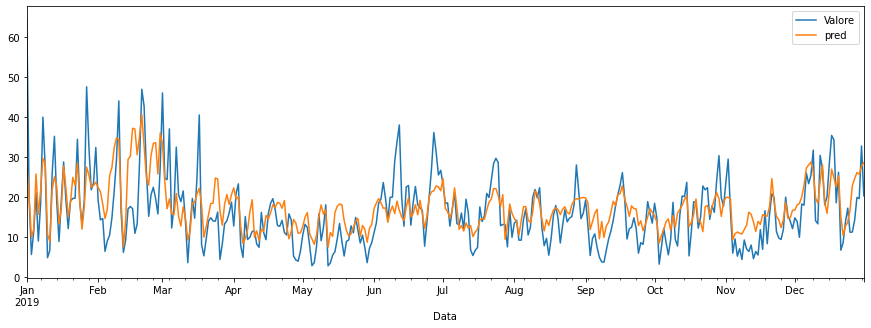

In [273]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

(-5.0, 105.0)

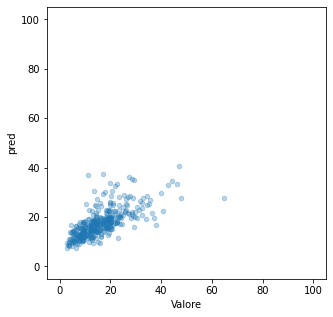

In [274]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

In [275]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 4.81
Mean squared error: 40.50
Root mean squared error: 6.36


In [276]:
regressor.score(X_test, y_test)

0.4546586808835571

In [277]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

R²: 0.45465868088355677


In [280]:
importance_features = X_test.columns.tolist()
importance_values = regressor.feature_importances_.tolist()

importance_features_sorted = [x for _,x in sorted(zip(importance_values, importance_features))]
importance_values_sorted = sorted(importance_values)

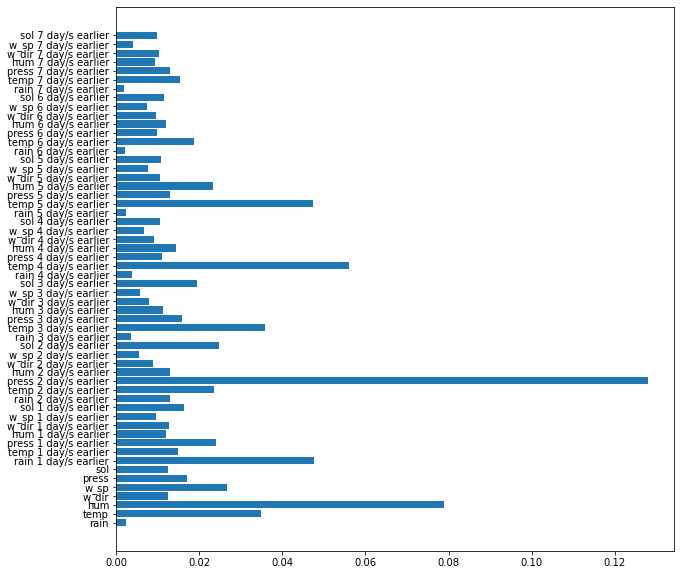

In [281]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns,regressor.feature_importances_)

plt.show()

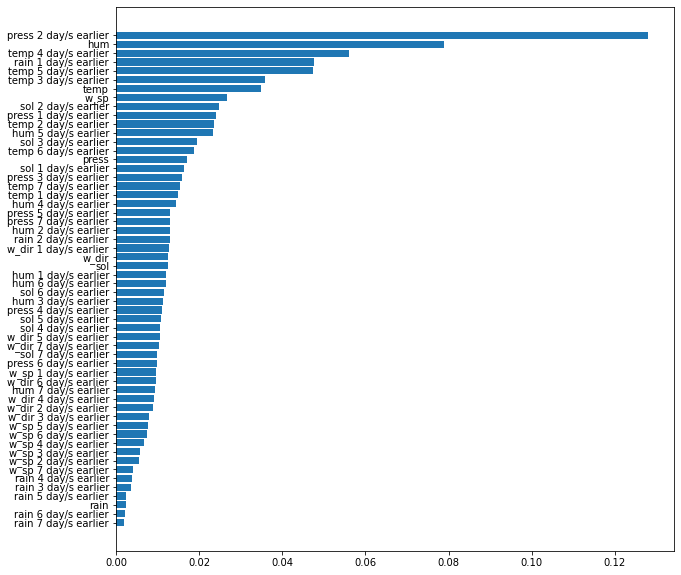

In [282]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(importance_features_sorted, importance_values_sorted)

plt.show()

In [283]:
old_feat_sum = {
    "rain" : 0,
    "temp" : 0,
    "hum" : 0,
    "w_dir" : 0,
    "w_sp" : 0,
    "press" : 0,
    "sol" : 0
}
feat_sum = {
    "Precipitation" : 0,
    "Temperature" : 0,
    "Humidity" : 0,
    "Wind direction" : 0,
    "Wind speed" : 0,
    "Atmospheric pressure" : 0,
    "Solar radiation" : 0
}

for feat, val in zip(importance_features_sorted, importance_values_sorted):
    old_feat_sum[feat.split()[0]] += val

old_feat_sum

{'rain': 0.07661459030666505,
 'temp': 0.2464956536594612,
 'hum': 0.1739541397984941,
 'w_dir': 0.08137351083443732,
 'w_sp': 0.07367651416906384,
 'press': 0.2319076321042254,
 'sol': 0.11597795912765313}

In [284]:


feat_sum["Precipitation"] = old_feat_sum["rain"]
feat_sum["Temperature"] = old_feat_sum["temp"]
feat_sum["Humidity"] = old_feat_sum["hum"]
feat_sum["Wind direction"] = old_feat_sum["w_dir"]
feat_sum["Wind speed"] = old_feat_sum["w_sp"]
feat_sum["Atmospheric pressure"] = old_feat_sum["press"]
feat_sum["Solar radiation"] = old_feat_sum["sol"]

feat_sum

{'Precipitation': 0.07661459030666505,
 'Temperature': 0.2464956536594612,
 'Humidity': 0.1739541397984941,
 'Wind direction': 0.08137351083443732,
 'Wind speed': 0.07367651416906384,
 'Atmospheric pressure': 0.2319076321042254,
 'Solar radiation': 0.11597795912765313}

In [285]:
features_list = feat_sum.keys()
values_list = feat_sum.values()
list(features_list)
list(values_list)

[0.07661459030666505,
 0.2464956536594612,
 0.1739541397984941,
 0.08137351083443732,
 0.07367651416906384,
 0.2319076321042254,
 0.11597795912765313]

In [315]:
features_list_sorted = [x for _,x in sorted(zip(values_list, features_list))]
values_list_sorted = sorted(values_list)

In [316]:
features_list_sorted

['Wind speed',
 'Precipitation',
 'Wind direction',
 'Solar radiation',
 'Humidity',
 'Atmospheric pressure',
 'Temperature']

In [321]:
values_list_sorted_mult_by_100 = list(map(lambda x: x*100, values_list_sorted))
values_list_sorted_mult_by_100

[7.3676514169063845,
 7.661459030666505,
 8.137351083443733,
 11.597795912765314,
 17.395413979849412,
 23.190763210422542,
 24.64956536594612]

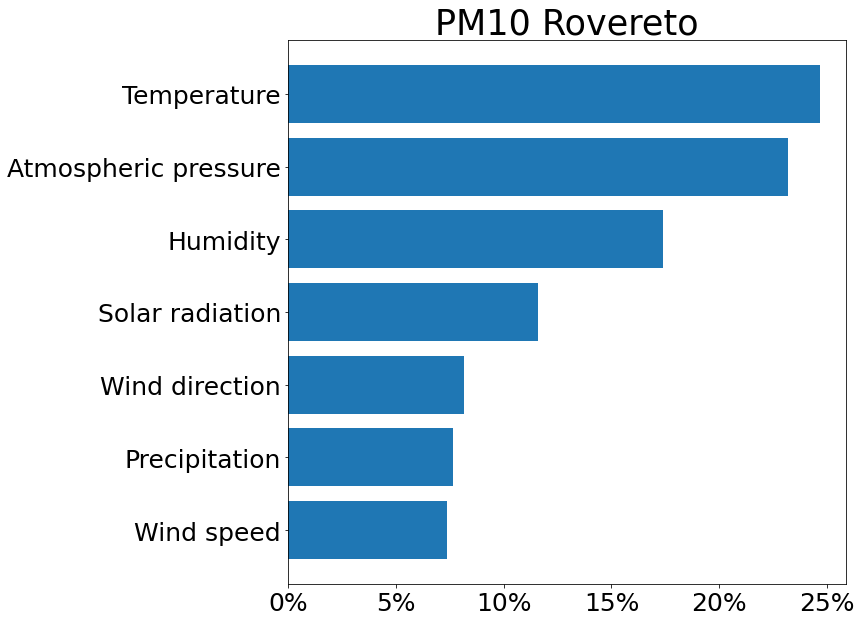

In [332]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(features_list_sorted, values_list_sorted_mult_by_100)

plt.title("PM10 Rovereto", fontsize=35)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

fmt = "%.0f%%"
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)

plt.show()

In [290]:
input_columns[22]

'temp 3 day/s earlier'

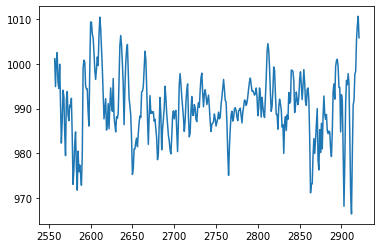

In [291]:
plt.plot(test_chart_data["press"])

In [292]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

# Simulazione

In [293]:
test_chart_data.loc[:, "doy"] = test_chart_data.Data.dt.dayofyear
test_chart_data

C:\Users\thoma\AppData\Local\Temp\ipykernel_2228\3115695229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data.loc[:, "doy"] = test_chart_data.Data.dt.dayofyear


,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier,pred,doy
2557,2019-01-01,64.625000,0.0,1.3,rov,87.4,1.0,0.3,1001.1,1378.9,...,0.7,4082.8,3837.7,3926.1,3839.4,3971.0,3957.7,3647.9,27.880195,1
2558,2019-01-02,19.666667,0.0,3.5,rov,56.7,20.0,1.6,994.9,4525.2,...,0.5,1378.9,4082.8,3837.7,3926.1,3839.4,3971.0,3957.7,20.124452,2
2559,2019-01-03,5.708333,0.0,4.8,rov,24.2,297.0,2.1,1000.6,4403.8,...,0.6,4525.2,1378.9,4082.8,3837.7,3926.1,3839.4,3971.0,10.006391,3
2560,2019-01-04,11.458333,0.0,1.2,rov,46.8,67.0,0.7,1002.5,3800.9,...,0.8,4403.8,4525.2,1378.9,4082.8,3837.7,3926.1,3839.4,12.031707,4
2561,2019-01-05,21.166667,0.0,2.7,rov,59.2,348.0,0.8,995.8,4268.9,...,0.5,3800.9,4403.8,4525.2,1378.9,4082.8,3837.7,3926.1,25.839274,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2019-12-27,14.250000,0.0,3.0,rov,78.8,357.0,0.5,998.3,3953.2,...,0.2,3796.4,3990.9,2369.2,3942.0,2326.3,1156.8,191.6,24.655853,361
2918,2019-12-28,19.958333,0.0,2.2,rov,84.5,46.0,0.6,1005.4,3879.8,...,1.1,3953.2,3796.4,3990.9,2369.2,3942.0,2326.3,1156.8,26.186232,362
2919,2019-12-29,19.708333,0.0,0.6,rov,82.7,19.0,0.4,1008.6,4117.7,...,0.9,3879.8,3953.2,3796.4,3990.9,2369.2,3942.0,2326.3,25.784959,363
2920,2019-12-30,32.833333,0.0,0.2,rov,86.2,350.0,0.3,1010.6,3966.7,...,0.4,4117.7,3879.8,3953.2,3796.4,3990.9,2369.2,3942.0,27.747636,364


In [294]:
def get_season(doy):
    if doy < datetime(2022, 3, 21).timetuple().tm_yday:
        return "winter"
    elif doy < datetime(2022, 6, 21).timetuple().tm_yday:
        return "spring"
    elif doy < datetime(2022, 9, 21).timetuple().tm_yday:
        return "summer"
    elif doy < datetime(2022, 12, 21).timetuple().tm_yday:
        return "fall"
    else:
        return "winter"

In [295]:
test_chart_data["season"] = test_chart_data.doy.map(get_season)

C:\Users\thoma\AppData\Local\Temp\ipykernel_2228\3540010652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["season"] = test_chart_data.doy.map(get_season)


In [296]:
test_chart_data[test_chart_data.season == "fall"].sol.mean()
#15600 - 18000 - 5887 - 8000

5134.186813186812

In [297]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

In [298]:
def run_simulation(
    X,
    simulation_variable, 
    change, 
    change_as_perc,
    need_threshold,
    threshold,
):
    X_simulation = X[input_columns].copy()
    # ['rain','temp','hum','w_dir','w_sp','press','sol']

    simulation_results = {}

    sim_var_columns = X_simulation.columns[
        X_simulation.columns.str.contains(f"^{simulation_variable}")
    ]

    X_simulation_high = X_simulation.copy()
    if change_as_perc:
        X_simulation_high.loc[:, sim_var_columns] *= (1 + change)
    else:
        X_simulation_high.loc[:, sim_var_columns] += change
    if need_threshold:
        X_simulation_high.loc[:, sim_var_columns] = X_simulation_high[sim_var_columns].clip(upper=threshold)


    X_simulation_low = X_simulation.copy()
    if change_as_perc:
        X_simulation_low.loc[:, sim_var_columns] *= (1 - change)
    else:
        X_simulation_low.loc[:, sim_var_columns] -= change

    simulation_results["ref"] = regressor.predict(X_simulation)  # takes the predicted value
    simulation_results["low"] = regressor.predict(X_simulation_low)  # takes the predicted value
    simulation_results["high"] = regressor.predict(X_simulation_high)  # takes the predicted value

    simulation_results = pd.DataFrame(simulation_results)

    return simulation_results

In [299]:
year = 2019
test_chart_data_year = test_chart_data[test_chart_data.Data.dt.year == year]

exps = [{
    "simulation_variable": "hum",
    "change": 0.05,
    "change_as_perc": True,
    "need_threshold": True,
    "threshold": 100
}, {
    "simulation_variable": "press",
    "change": 10,
    "change_as_perc": False,
    "need_threshold": False,
    "threshold": None
}, {
    "simulation_variable": "rain",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": True,
    "threshold": 1000
}, {
    "simulation_variable": "temp",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": False,
    "threshold": None
}, {
    "simulation_variable": "w_sp",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": True,
    "threshold": 1000
}, {
    "simulation_variable": "sol",
    "change": 1500,
    "change_as_perc": False,
    "need_threshold": False,
    "threshold": None
}]

simulation_results = {}

for exp in exps:
    simulation_result = run_simulation(
        test_chart_data_year,
        **exp
    )

    print(exp["change"], exp["change_as_perc"])


    simulation_result["season"] = test_chart_data_year.season.values


    simulation_result = (
        simulation_result
        .melt(id_vars=["season"])
        .set_index("variable")
        .loc[["low", "ref", "high"]]
        .reset_index()
    )
    simulation_results[exp["simulation_variable"]] = simulation_result

0.05 True
10 False
1 False
1 False
1 False
1500 False


In [300]:
def do_box_plot(param, title, ylab):
    df_box = simulation_results[param].copy()
    df_box = df_box[df_box.season.isin(["winter", "summer"])]

    # Need to find the dict that contains the "param" parameter in the list exps
    exp_needed = None
    for exp in exps:
        if exp["simulation_variable"] == param:
            exp_needed = exp
    
    if exp == None:
        print("------------------------ERROR--------------------------------")

    condition_to_unit = {"rain": "mm", "temp": "°C", "hum": "%", "w_sp": "m/s", "press": "hPa", "sol": "kJ/m2"}
    condition_to_description = {
        "rain": "precipitation",
        "temp": "temperature",
        "hum" : "relative humidity",
        "w_sp": "wind speed",
        "press": "atmospheric pressure",
        "sol": "solar radiation"
    }

    low_value = f'-{int(float(exp_needed["change"])*100) if exp_needed["change_as_perc"] else exp_needed["change"]}{"%" if exp_needed["change_as_perc"] else ""} {condition_to_unit[exp_needed["simulation_variable"]]}'
    reference = "Reference"
    high_value = f'+{int(float(exp_needed["change"])*100) if exp_needed["change_as_perc"] else exp_needed["change"]}{"%" if exp_needed["change_as_perc"] else ""} {condition_to_unit[exp_needed["simulation_variable"]]}'
    
    df_box["variable"] = df_box.variable.map({
        "low": low_value, 
        "ref": reference,
        "high": high_value
    })

    df_box = df_box.rename({"variable": "Values"}, axis=1)

    ax = sns.boxplot(
        x="season",
        y="value",
        hue="Values",
        data=df_box
    )
    
    ax.set_title(title)
    ax.set_xlabel("Average " + condition_to_description[param])
    ax.set_ylabel(ylab + " (μg/m3)")
    ax.grid(visible=True)
    


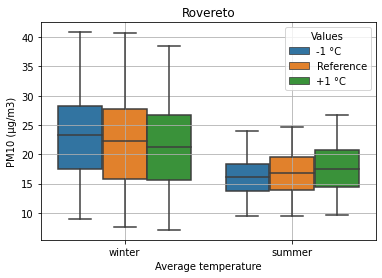

In [333]:
do_box_plot("temp", "Rovereto", "PM10")

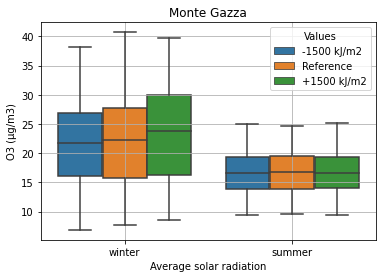

In [302]:
do_box_plot("sol", "Monte Gazza", "O3")